In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [31]:
CHANNELS=12

In [32]:
## LOAD MY DATA
images_path = "/kaggle/input/flood-dediction/data/images"
labels_path = "/kaggle/input/flood-dediction/data/labels"

In [33]:
IMG_HEIGHT, IMG_WIDTH = 512, 512   # from your diagram
IMG_CHANNELS = 12 

## Loading images and labels

In [34]:
!pip install rasterio

In [35]:
pip install --upgrade numpy


Note: you may need to restart the kernel to use updated packages.


In [36]:
print(sorted(os.listdir(images_path))[:10])
print(sorted(os.listdir(labels_path))[:10])

['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif']
['0.png', '1.png', '10.png', '100.png', '100_184.png', '101.png', '101_89.png', '102.png', '102_179.png', '103.png']


In [37]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import rasterio

X, Y = [], []

image_files = sorted([f for f in os.listdir(images_path) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith(".png")])

for img_file in image_files:
    base = os.path.splitext(img_file)[0]   
    matching = [lbl for lbl in label_files if lbl.startswith(base)]
    if not matching:
        continue
    
    lbl_file = matching[0]  # ناخد أول  ماسك بس

    # اقرأ الصورة (12-Channel)
    with rasterio.open(os.path.join(images_path, img_file)) as src:
        img = src.read()
        img = np.transpose(img, (1,2,0))
        X.append(img)

    # اقرأ الماسك (Grayscale PNG)
    mask = load_img(os.path.join(labels_path, lbl_file), color_mode="grayscale", target_size=(128,128))
    mask = img_to_array(mask)
    mask = (mask > 127).astype(np.float32)
    Y.append(mask)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print("Final Images:", X.shape)
print("Final Masks:", Y.shape)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Final Images: (306, 128, 128, 12)
Final Masks: (306, 128, 128, 1)


## Normalize features

# Min-max normalization per band
X_min = X.min(axis=(0,1,2), keepdims=True)
X_max = X.max(axis=(0,1,2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

## Data Preprocessing

### Train-validation split

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [39]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(244, 128, 128, 12) (62, 128, 128, 12) (244, 128, 128, 1) (62, 128, 128, 1)


## Data Augmentation

In [40]:
!pip install imgaug

In [41]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [42]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(X_train.shape[0]):
    image = X_train[i]
    mask = Y_train[i]
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

In [43]:
if augmented_masks.ndim == 3:  
    augmented_masks = np.expand_dims(augmented_masks, axis=-1)  

In [44]:
# append augmented images/masks with original images/masks
train_x= np.concatenate((X_train, augmented_images), axis=0)
train_y = np.concatenate((Y_train, augmented_masks), axis=0)

In [45]:
# release memory
del augmented_images
del augmented_masks

In [47]:
train_x.shape, train_y.shape

((976, 128, 128, 12), (976, 128, 128, 1))

# Shuffling
num_samples = train_x.shape[0]
shuffled_indices = np.random.permutation(num_samples)

train_x = train_x[shuffled_indices]
train_y = train_y[shuffled_indices]

## Function to build the model (U_Net)

In [65]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# U-Net model using functions
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  # regularization
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input_tensor)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [66]:
# input: (128,128,12)
inputs = Input((128, 128, 12))

# Encoder
s1, p1 = encoder_block(inputs, 16)
s2, p2 = encoder_block(p1, 32)
s3, p3 = encoder_block(p2, 64)
s4, p4 = encoder_block(p3, 128)

# Bottleneck
b1 = conv_block(p4, 256)

# Decoder
d1 = decoder_block(b1, s4, 128)
d2 = decoder_block(d1, s3, 64)
d3 = decoder_block(d2, s2, 32)
d4 = decoder_block(d3, s1, 16)

# Output layer
outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

model = Model(inputs, outputs)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 128, 128,  │      1,744 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_89[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_10[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_22… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_91[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_11[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_92[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_23… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_93[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_12[0][0]

 Total params: 1,948,289 (7.43 MB)

 Trainable params: 1,945,345 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [67]:
from tensorflow import keras
model.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

## Training the model

In [68]:
history = model.fit(train_x, train_y, batch_size=28, epochs=20, validation_split = 0.2)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 924ms/step - accuracy: 0.5742 - loss: 0.7392 - val_accuracy: 0.7411 - val_loss: 0.6812
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9871 - loss: 0.5995 - val_accuracy: 0.9803 - val_loss: 0.5326
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9977 - loss: 0.5168 - val_accuracy: 0.9996 - val_loss: 0.4462
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9992 - loss: 0.4319 - val_accuracy: 0.9999 - val_loss: 0.3624
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9997 - loss: 0.3503 - val_accuracy: 0.9999 - val_loss: 0.2933
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9998 - loss: 0.2778 - val_accuracy: 0.9999 - val_loss: 0.2297
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9999 - loss: 0.2176 - val_accuracy: 0.9999 - val_loss: 0.1803
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9999 - loss: 0.1700 - val_accuracy: 0.9999 -

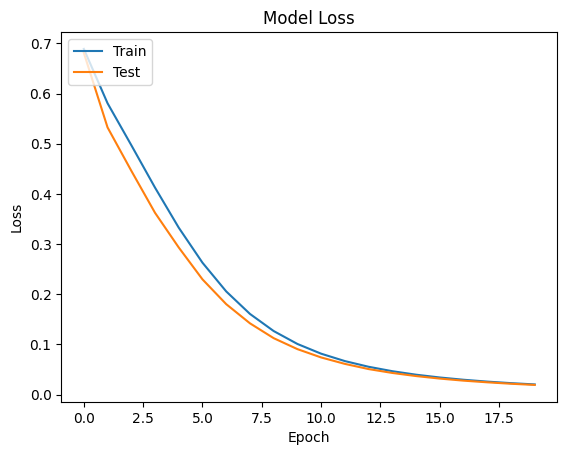

In [74]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()     

## Saving Model 

In [88]:
model.save('Flood_Detection.h5')